In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
import climdex.temperature as tdex
from normalizing_flows.models import VariationalModel, FlowLVM, JointFlowLVM, adversarial
from normalizing_flows.models.variational import nll_loss
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Transform, Flow, Invert
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
from utils.distributions import normal
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 30).argmin().values
    seus_lat_en = seus_lat_st + 8*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 16*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_1, ras_seus_maxt_14))

In [5]:
def preprocess_vds(data_lo, data_hi, batch_size=100, buffer_size=1000):
    data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    return data.batch(batch_size)

In [6]:
indices = tdex.indices('Time')
def eval_climdex(true, pred, coords):
    true_arr = xr.DataArray(true, coords=coords)
    pred_arr = xr.DataArray(pred, coords=coords)
    txx_true = indices.monthly_txx(true_arr)
    txx_pred = indices.monthly_txx(pred_arr)
    txn_true = indices.monthly_txn(true_arr)
    txn_pred = indices.monthly_txn(pred_arr)
    txx_bias = txx_pred - txx_true
    txn_bias = txn_pred - txn_true
    return txx_bias, txn_bias

### Baseline: Vanilla inference network for downscaling

$f: X \rightarrow \Theta$, $\hat{y} \sim p(\Theta)$

In [ ]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 5
def rmse(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
def bias(y_true, y_pred):
    return tf.math.reduce_mean(y_pred - y_true, axis=[1,2,3])
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size)
    #vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    vdsrcnn = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
    vdsrcnn = VariationalModel(normal(), inputs=vdsrcnn.inputs, outputs=vdsrcnn.outputs)
    vdsrcnn.compile(optimizer=Adamax(lr=1.0E-3), metrics=[rmse, bias])
    vdsrcnn.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
                validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    pred = vdsrcnn.predict_mean(test_x)
    sample = vdsrcnn.sample(test_x, sample_fn=lambda d: d.distribution.loc + d.distribution.scale*tf.random.normal((sample_batch_size,1,1,1)))
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()

### Glow: Latent variable estimation

The goal of variational inference is to estimate $q(z) \approx p(z|x) = \frac{p(x,z)}{\int p(x,z)dz}$

Normalizing flows attempt to learn an invertible function $f$ s.t. for $z_0$ drawn form initial variational density $q_0$, $z = f(z_0) \sim q(z)$, where $f$ is arbitrarily complex. This allows the model to learn better approximations of the posterior than otherwise possible with traditional, simple variational densities (such as a spherical Gaussian or standard logistic).

Glow (Kingma et al. 2018) is a state of the art normalizing flow designed for image data. It is an extension of RealNVP that generalizes the channel-wise permutation steps using an invertible 1x1 convolution.

In [ ]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 5
def rmse(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
def bias(y_true, y_pred):
    return tf.math.reduce_mean(y_pred - y_true, axis=[1,2,3])
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size)
    #vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    flow = Invert(GlowFlow(num_layers=3, depth=4, act_norm=True, coupling_nn_ctor=coupling_nn_glow(hidden_dims=128)))
    prior = tfp.distributions.Normal(0,1)
    vdsrcnn = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
    model = VariationalModel(normal(), prior, transform=flow, inputs=vdsrcnn.inputs, outputs=vdsrcnn.outputs)
    model.compile(optimizer=Adamax(lr=1.0E-5), output_shape=(None, wt_hi, ht_hi, 1), metrics=[rmse, bias])
    model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
                validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    sample = model.sample(test_x)
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[1].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()

#### Unsupervised, Glow-based latent variable models for downscaling

Fold 1/3
1200 training samples, 1200 test samples, 8x16 -> 32x64
Training joint model for 5 epochs (0/30 complete)


100%|██████████| 120/120 [00:53<00:00,  2.24it/s, nll_x=0.429, nll_y=1.01, gx_loss=-.25, gy_loss=0.059, dx_loss=0.719, dy_loss=0.561]   


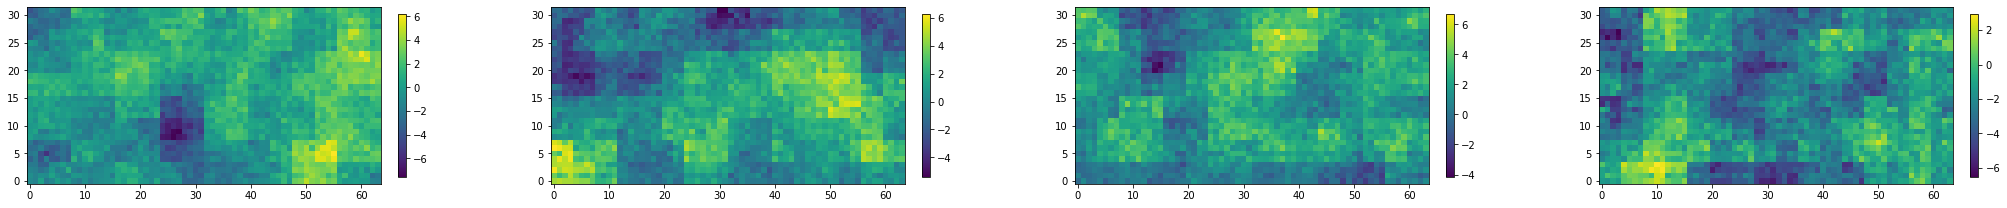

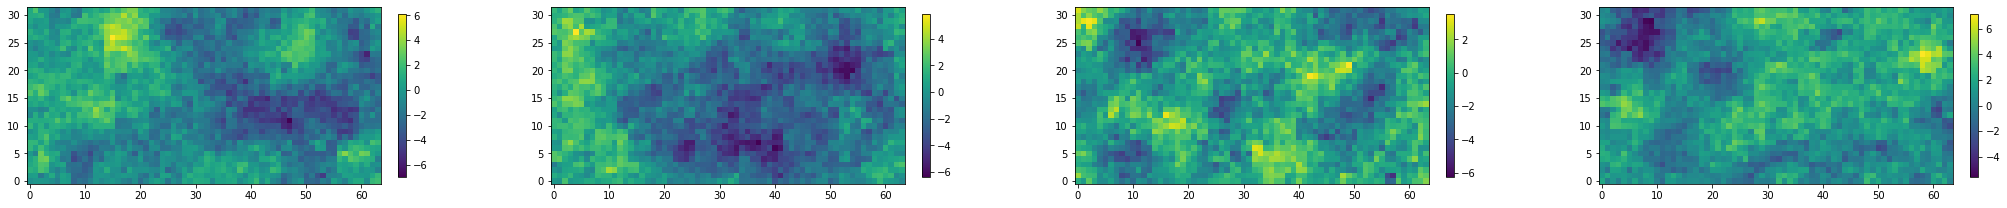

Evaluating ClimDEX indices on predictions
txx bias avg: -5.494163513183594, std: 2.3909852504730225
txn bias avg: 4.996793270111084, std: 3.353809356689453


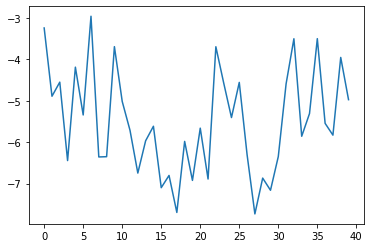

Training joint model for 5 epochs (5/30 complete)


100%|██████████| 120/120 [00:26<00:00,  4.59it/s, nll_x=-.112, nll_y=0.798, gx_loss=0.000384, gy_loss=-.0344, dx_loss=0.439, dy_loss=0.351]


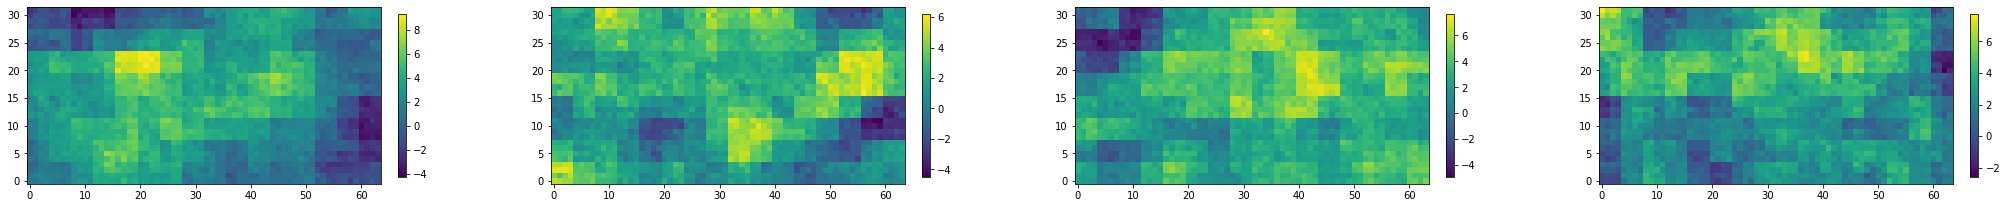

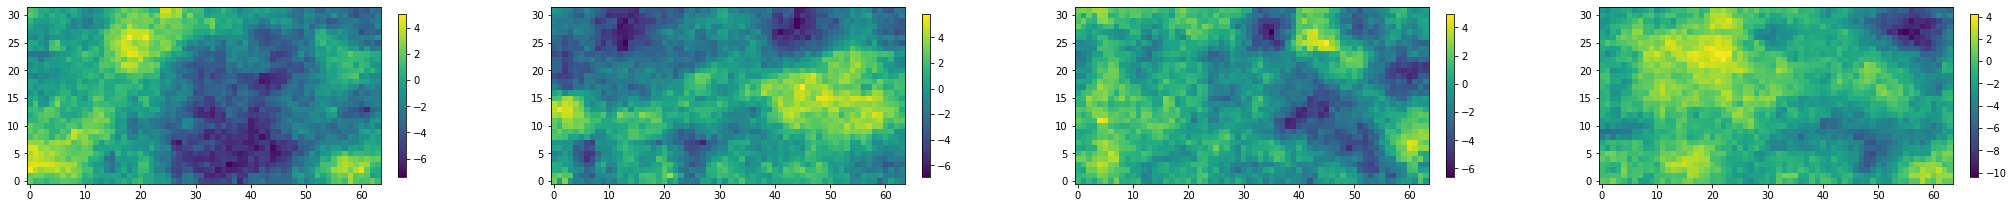

Evaluating ClimDEX indices on predictions
txx bias avg: -4.5311479568481445, std: 2.1043701171875
txn bias avg: 7.2682905197143555, std: 3.1760172843933105


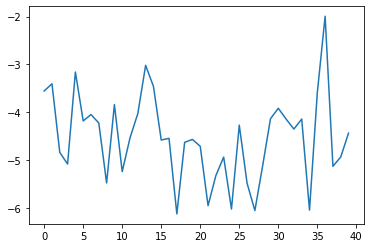

Training joint model for 5 epochs (10/30 complete)


100%|██████████| 120/120 [00:25<00:00,  4.64it/s, nll_x=-.572, nll_y=0.786, gx_loss=-.162, gy_loss=0.104, dx_loss=0.415, dy_loss=0.134]


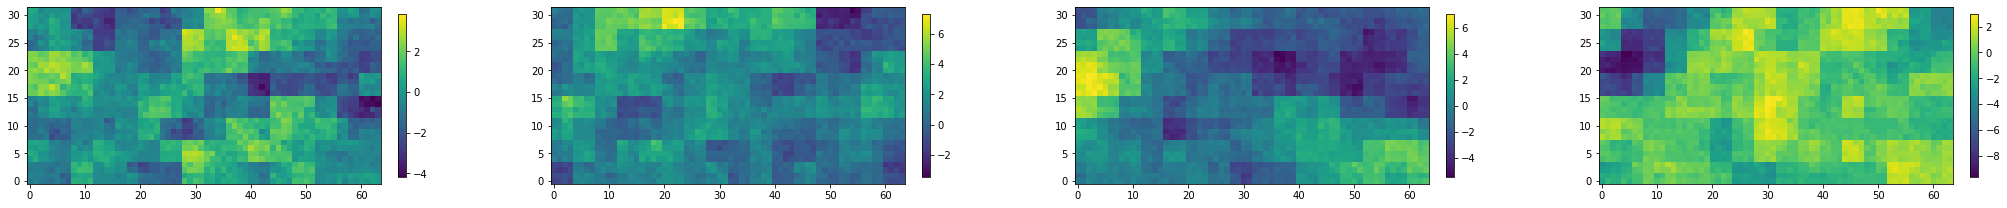

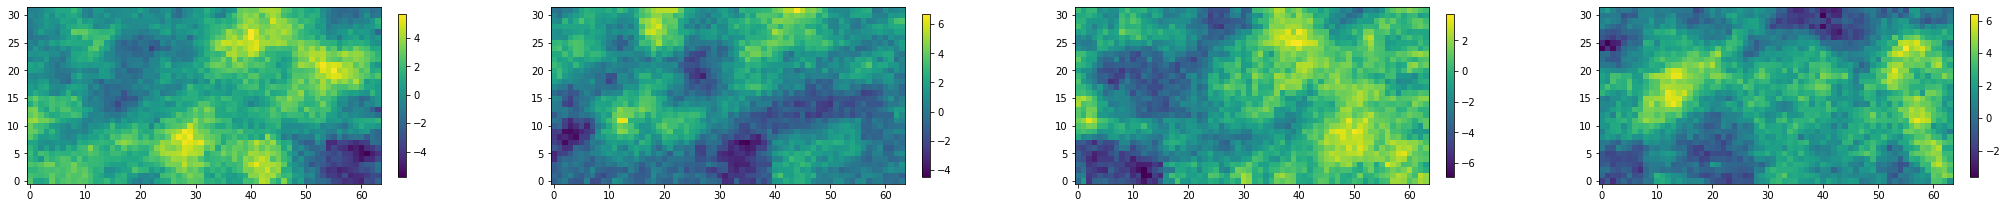

Evaluating ClimDEX indices on predictions
txx bias avg: -2.7850074768066406, std: 3.5586888790130615
txn bias avg: 4.8328752517700195, std: 3.957245349884033


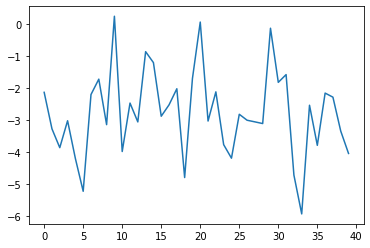

Training joint model for 5 epochs (15/30 complete)


100%|██████████| 120/120 [00:25<00:00,  4.76it/s, nll_x=-.871, nll_y=0.754, gx_loss=-.225, gy_loss=0.0806, dx_loss=0.185, dy_loss=0.03]  


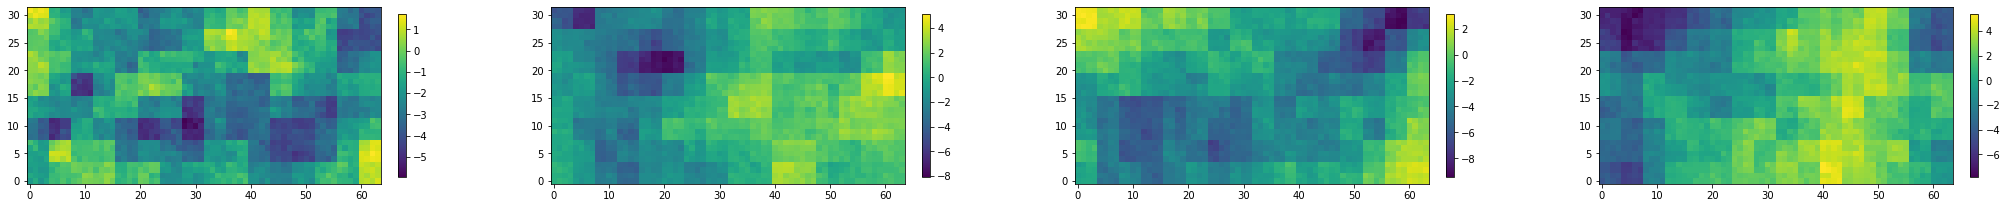

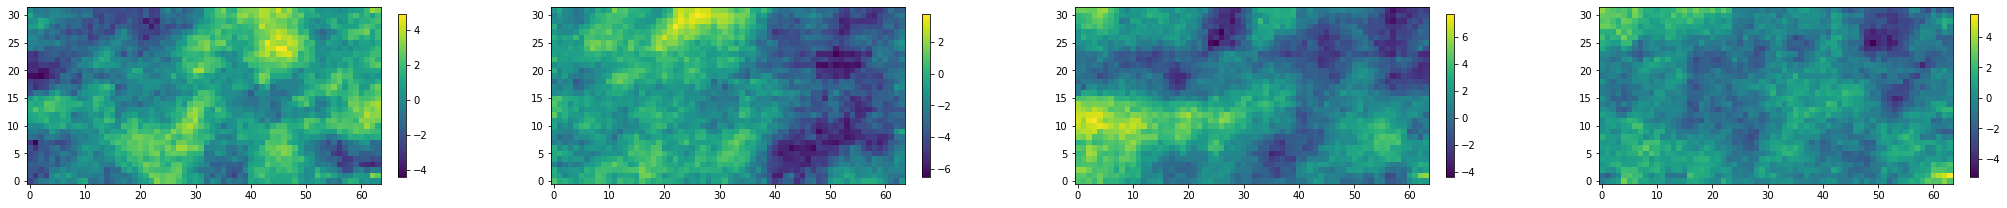

Evaluating ClimDEX indices on predictions
txx bias avg: -2.2444114685058594, std: 2.263350248336792
txn bias avg: 9.25637435913086, std: 3.30551815032959


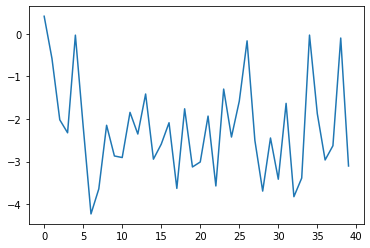

Training joint model for 5 epochs (20/30 complete)


100%|██████████| 120/120 [00:25<00:00,  4.76it/s, nll_x=-1.17, nll_y=0.678, gx_loss=0.0139, gy_loss=0.084, dx_loss=-.0127, dy_loss=0.0202] 


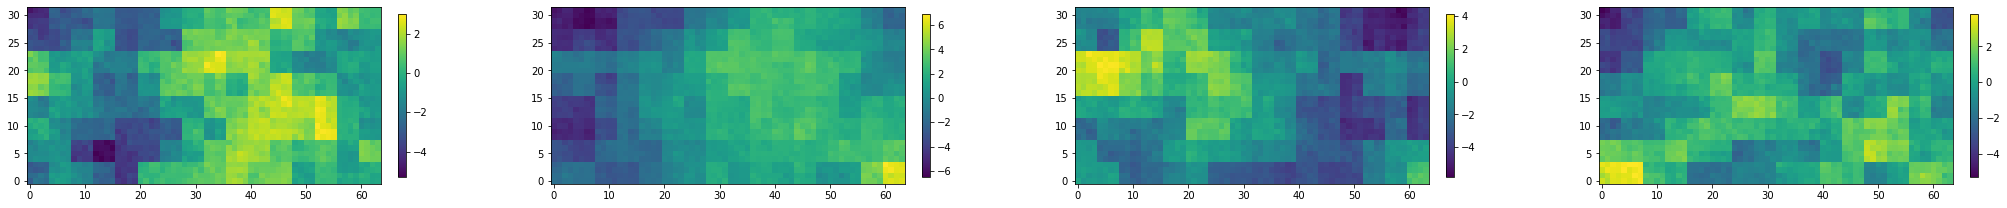

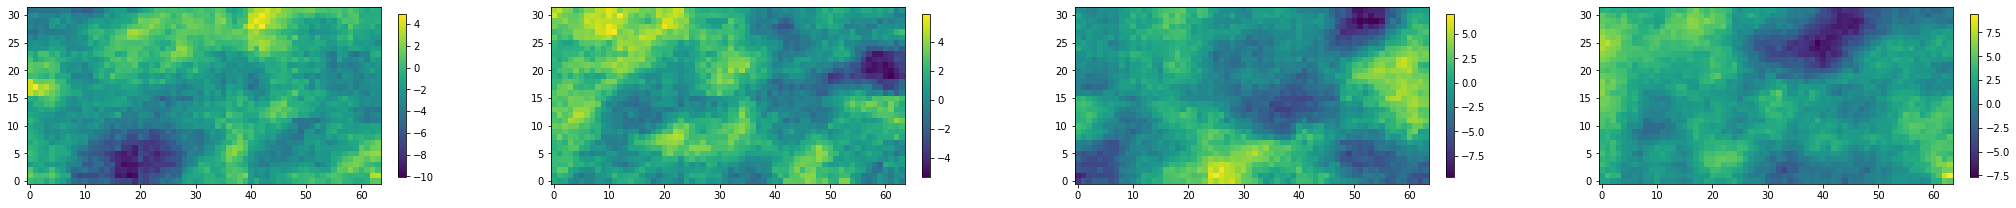

Evaluating ClimDEX indices on predictions
txx bias avg: -1.6944020986557007, std: 2.986011028289795
txn bias avg: 0.8678431510925293, std: 3.945712089538574


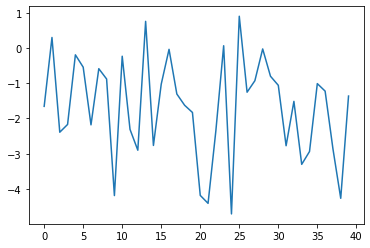

Training joint model for 5 epochs (25/30 complete)


100%|██████████| 120/120 [00:24<00:00,  4.99it/s, nll_x=-1.41, nll_y=0.687, gx_loss=0.0827, gy_loss=-.00794, dx_loss=-.0371, dy_loss=-.0155]


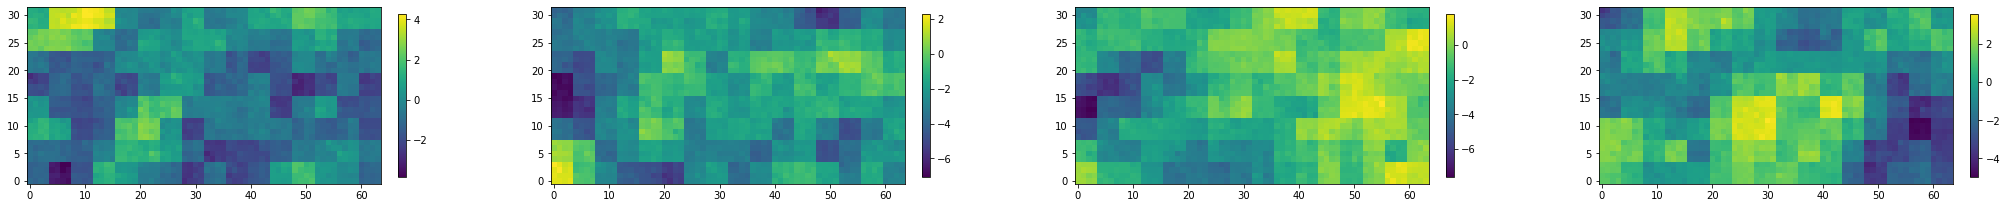

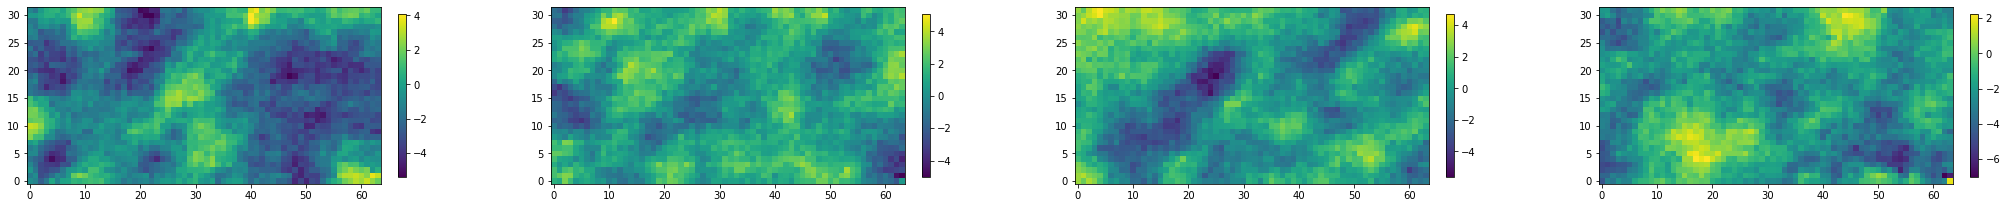

Evaluating ClimDEX indices on predictions
txx bias avg: -2.0639026165008545, std: 3.8570096492767334
txn bias avg: 0.049924060702323914, std: 4.14668607711792


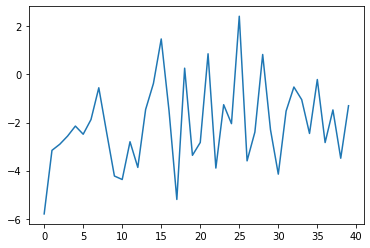

Fold 2/3
2400 training samples, 1200 test samples, 8x16 -> 32x64
Training joint model for 5 epochs (0/30 complete)


100%|██████████| 120/120 [00:47<00:00,  2.52it/s, nll_x=0.0317, nll_y=0.761, gx_loss=-.0841, gy_loss=0.078, dx_loss=1.39, dy_loss=0.323]  


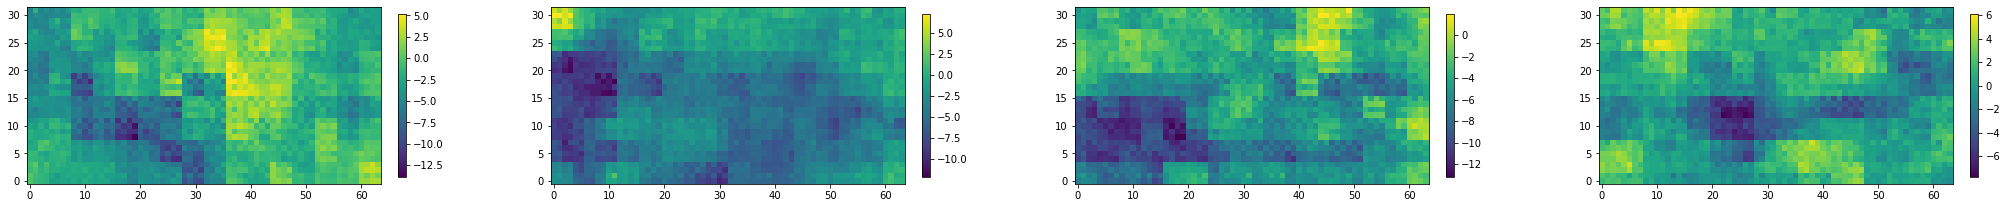

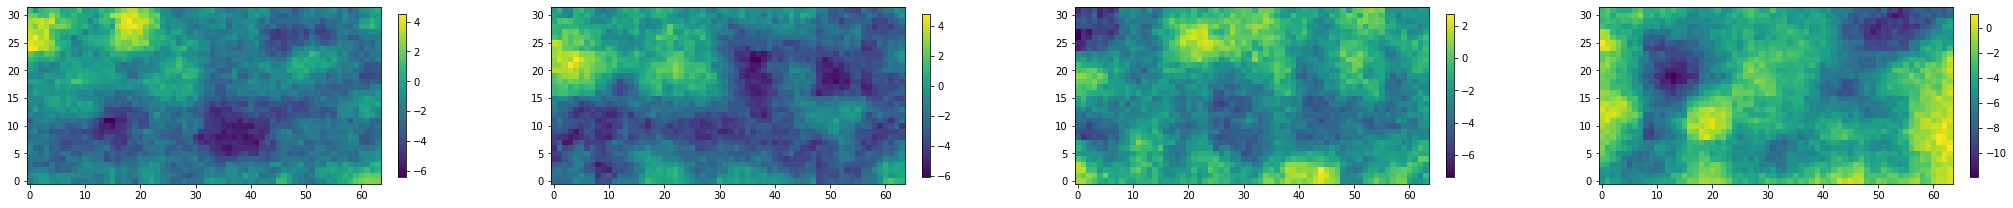

Evaluating ClimDEX indices on predictions
txx bias avg: -2.674680233001709, std: 3.777069091796875
txn bias avg: 1.4359863996505737, std: 3.8102245330810547


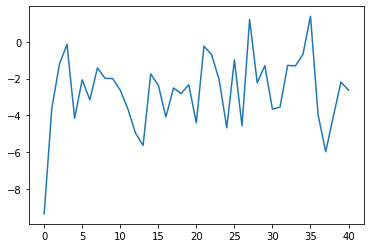

Training joint model for 5 epochs (5/30 complete)


100%|██████████| 120/120 [00:24<00:00,  4.82it/s, nll_x=-.728, nll_y=0.7, gx_loss=-.0843, gy_loss=0.137, dx_loss=-.12, dy_loss=0.131]   


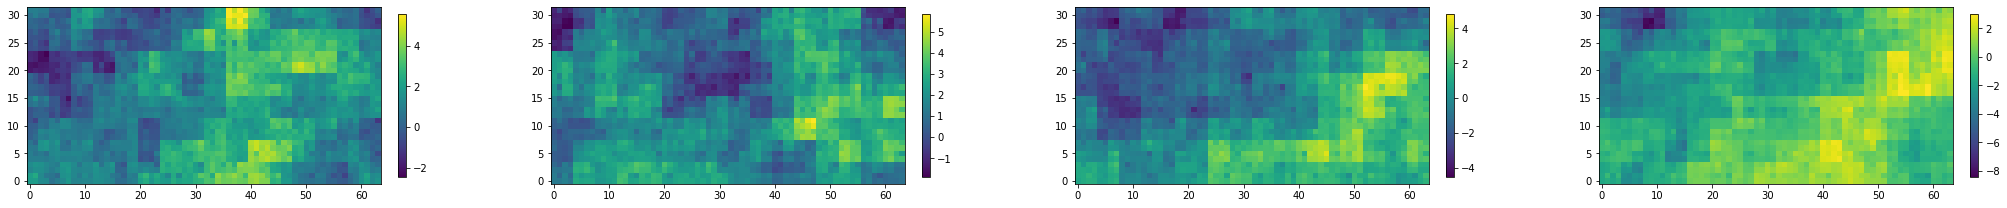

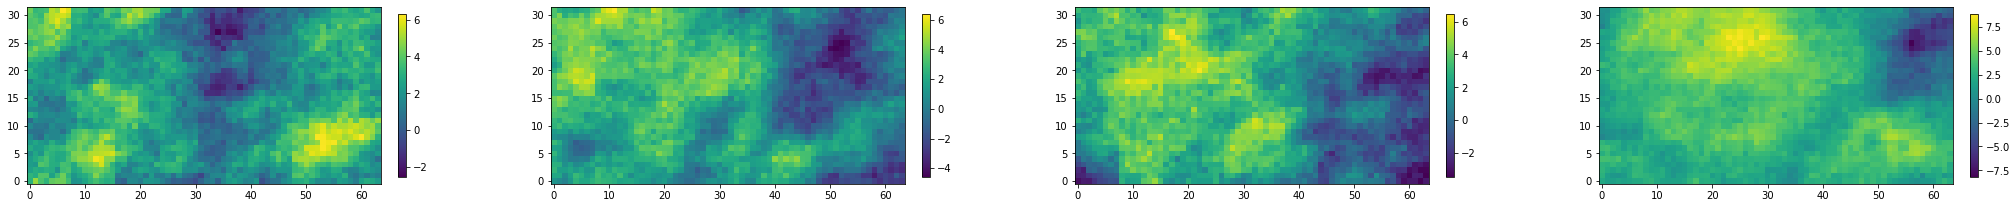

Evaluating ClimDEX indices on predictions
txx bias avg: 8.620068550109863, std: 5.973510265350342
txn bias avg: 8.942177772521973, std: 4.696996212005615


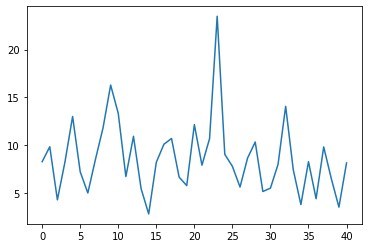

Training joint model for 5 epochs (10/30 complete)


100%|██████████| 120/120 [00:24<00:00,  4.92it/s, nll_x=-1.28, nll_y=0.69, gx_loss=-.183, gy_loss=0.111, dx_loss=0.0235, dy_loss=-.00285] 


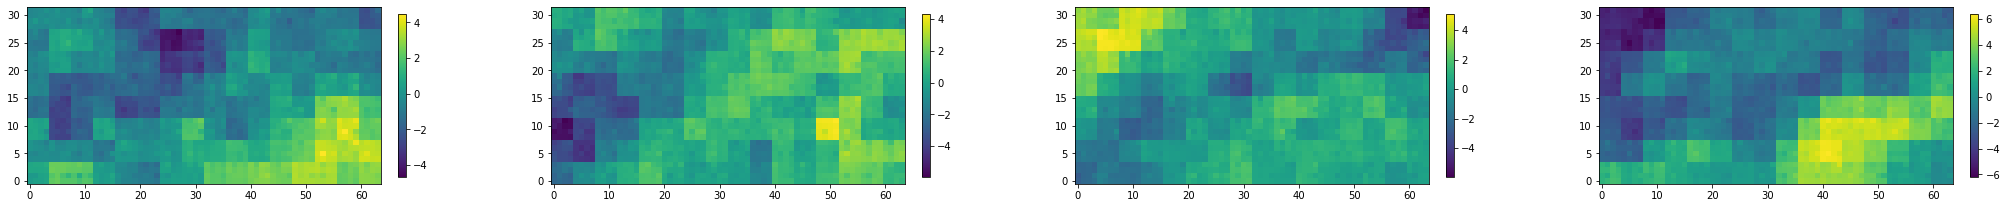

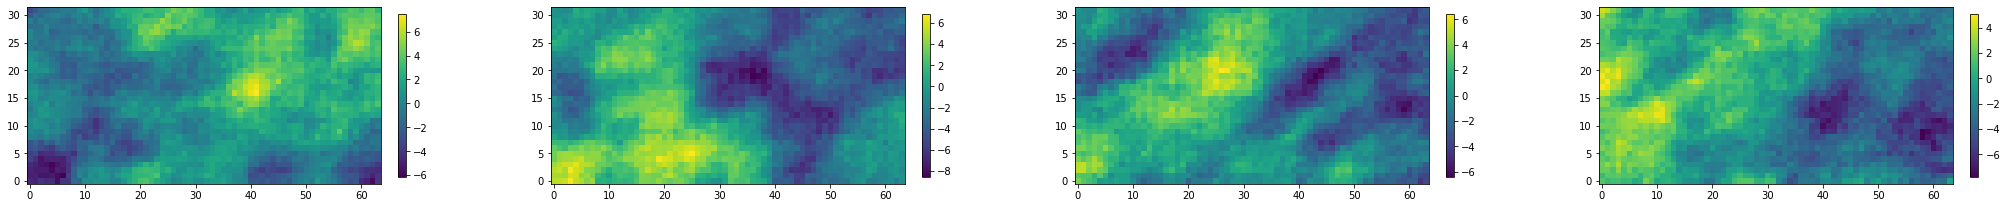

Evaluating ClimDEX indices on predictions
txx bias avg: -6.878084659576416, std: 3.3148550987243652
txn bias avg: -2.555513858795166, std: 4.21770715713501


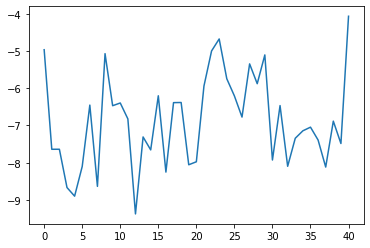

Training joint model for 5 epochs (15/30 complete)


100%|██████████| 120/120 [00:23<00:00,  5.05it/s, nll_x=-1.78, nll_y=0.672, gx_loss=-.092, gy_loss=0.0373, dx_loss=0.0087, dy_loss=-.0685]  


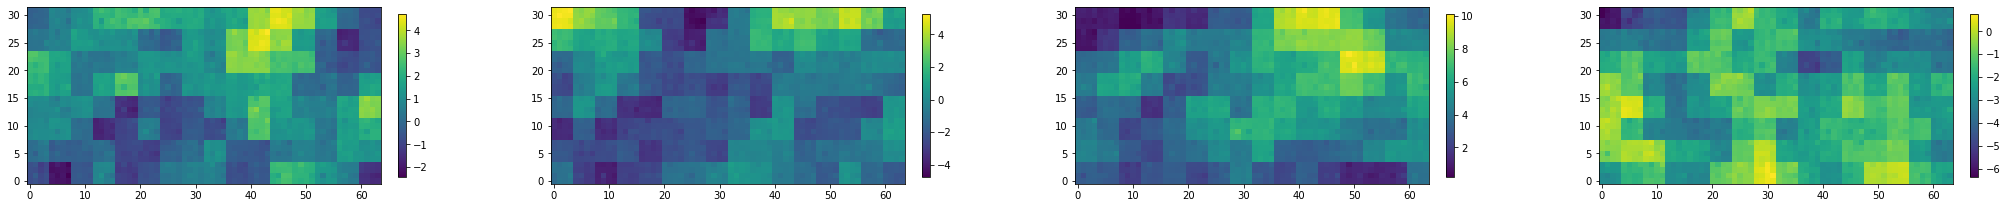

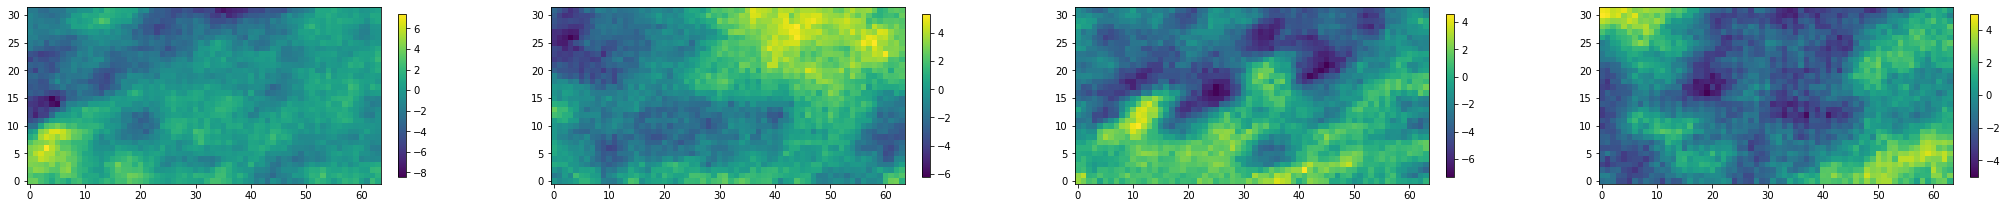

Evaluating ClimDEX indices on predictions
txx bias avg: -3.5464634895324707, std: 2.252065896987915
txn bias avg: 2.6910250186920166, std: 3.9376158714294434


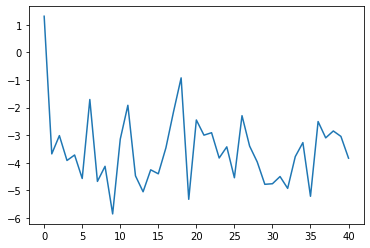

Training joint model for 5 epochs (20/30 complete)


100%|██████████| 120/120 [00:24<00:00,  4.93it/s, nll_x=-2.09, nll_y=0.634, gx_loss=-.115, gy_loss=0.092, dx_loss=-.101, dy_loss=-.0798] 


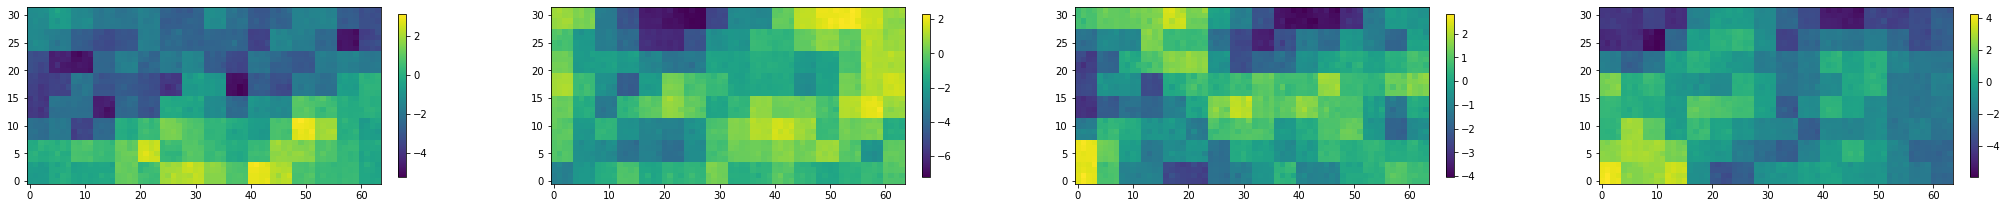

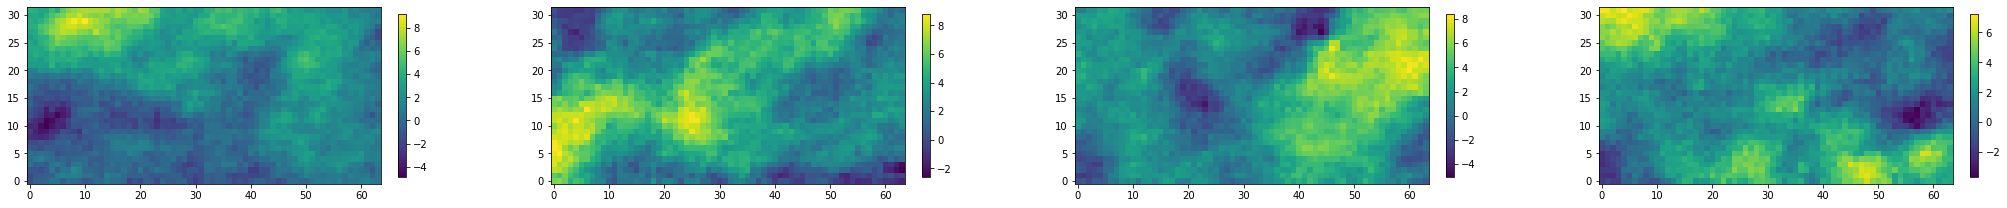

Evaluating ClimDEX indices on predictions
txx bias avg: -9.033151626586914, std: 3.430551767349243
txn bias avg: -2.1684718132019043, std: 3.8950188159942627


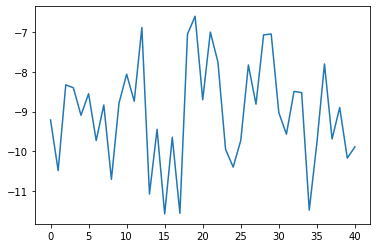

Training joint model for 5 epochs (25/30 complete)


100%|██████████| 120/120 [00:23<00:00,  5.12it/s, nll_x=-2.38, nll_y=0.59, gx_loss=-.186, gy_loss=0.233, dx_loss=-.0483, dy_loss=-.0854] 


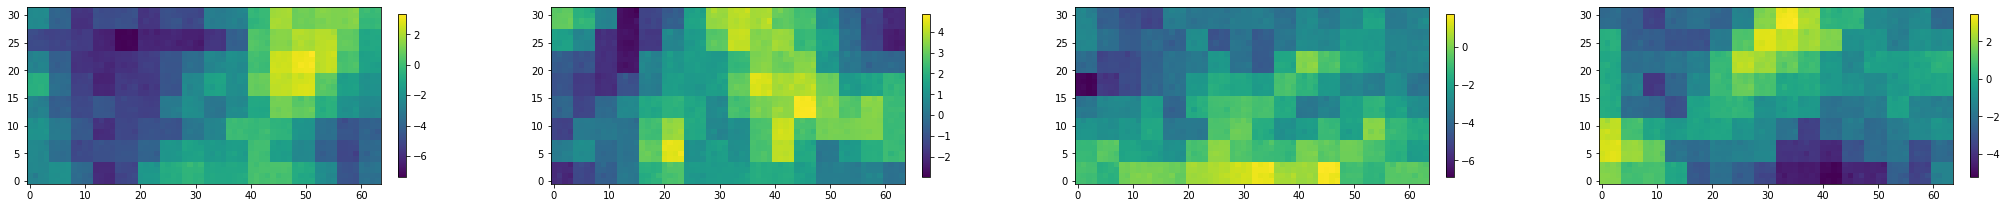

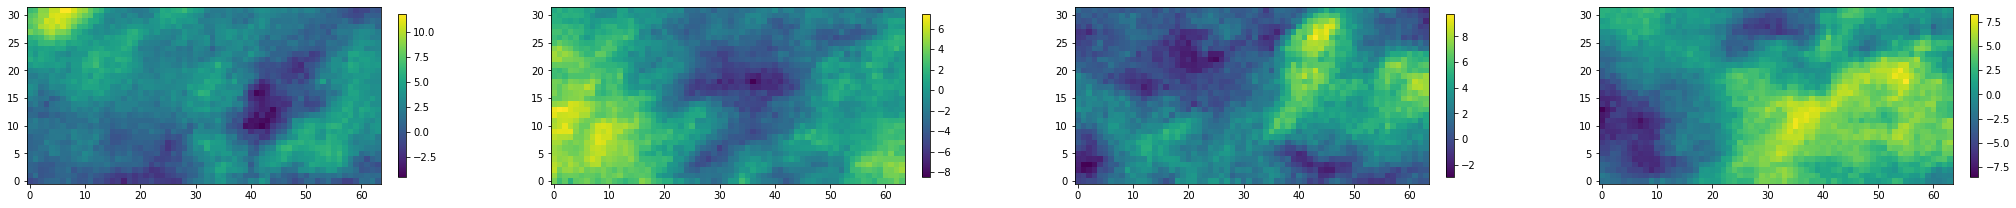

Evaluating ClimDEX indices on predictions
txx bias avg: 6.538051128387451, std: 3.808943271636963
txn bias avg: 3.7891805171966553, std: 3.711469888687134


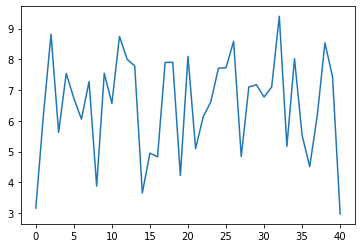

Fold 3/3
3600 training samples, 1148 test samples, 8x16 -> 32x64
Training joint model for 5 epochs (0/30 complete)


100%|██████████| 114/114 [00:46<00:00,  2.43it/s, nll_x=-.722, nll_y=0.655, gx_loss=0.395, gy_loss=0.276, dx_loss=0.304, dy_loss=0.632]


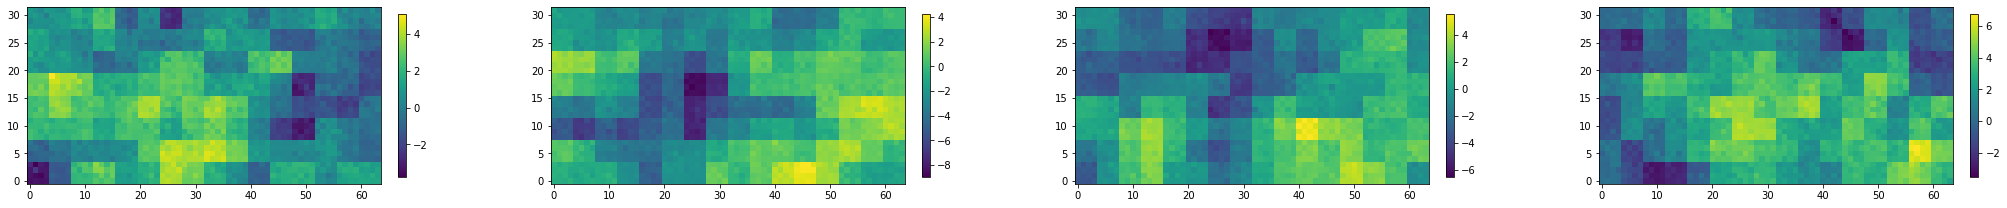

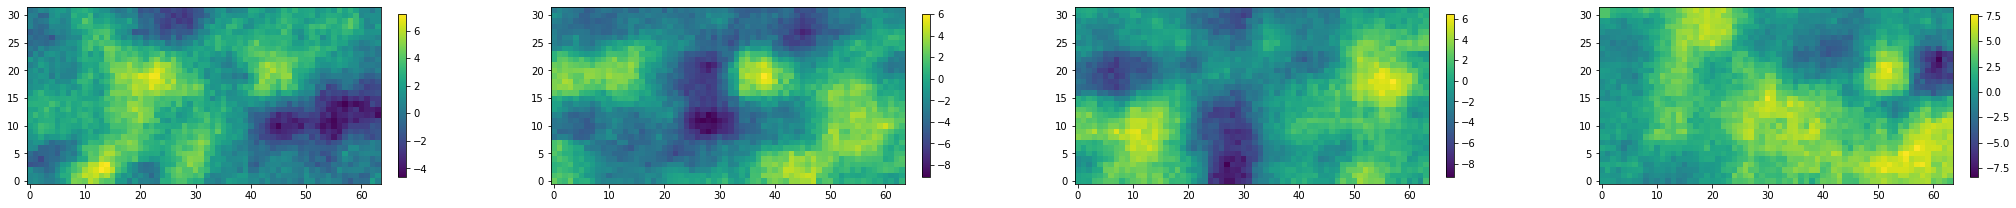

Evaluating ClimDEX indices on predictions
txx bias avg: 2.088731050491333, std: 5.767766952514648
txn bias avg: -33.93388748168945, std: 27.173046112060547


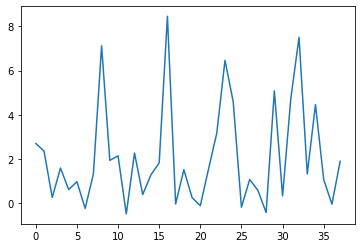

Training joint model for 5 epochs (5/30 complete)


 20%|██        | 360/1800 [01:51<04:56,  4.86it/s, g_obj=0.367, dx_loss=0.228, dy_loss=0.955, nll_x=-.846, nll_y=0.681]

In [ ]:
def plot_1xn(data):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()
    
def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

sample_batch_size = 10
load_batch_size = 1200
n_epochs = 30
validate_freq = 5
warmup_epochs = 1
models = []
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test)
    #train_ds = train_hi_ds.shuffle(N_train).batch(sample_batch_size)
    #test_ds = test_hi_ds.shuffle(N_test).batch(sample_batch_size)
    #cond_pred = cond_pred_nn((wt_hi, ht_hi, 1), wt_hi // wt, 1)
    flow_hr = Invert(GlowFlow(num_layers=3, depth=8, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    flow_lr = Invert(GlowFlow(num_layers=3, depth=8, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    #learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1.0E-3, N_train//sample_batch_size, 0.9)
    model_lr = FlowLVM(flow_lr, input_shape=(None,wt_hi,ht_hi,1), optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate))
    model_hr = FlowLVM(flow_hr, input_shape=(None,wt_hi,ht_hi,1), optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate))
#     print('Training low-res model', flush=True)
#     model_lr.train(train_ds.map(lambda x,y: x), steps_per_epoch=N_train//sample_batch_size, num_epochs=1)
#     samples_x = model_lr.sample(n=4)
#     plot_1xn(samples_x)
#     print('Training high-res model', flush=True)
#     model_hr.train(train_ds.map(lambda x,y: y), steps_per_epoch=N_train//sample_batch_size, num_epochs=1)
# #     break
#     samples_y = model_hr.sample(n=4)
#     plot_1xn(samples_y)
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy, input_shape=(None,wt_hi,ht_hi,1))
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq)
        model_joint.evaluate(test_ds, N_test//sample_batch_size)
#         x_lr, y_hr = next(test_ds.__iter__())
        samples_x, samples_y = model_joint.sample(n=4)
        plot_1xn(samples_x)
        plot_1xn(samples_y)
#         z_lr, _ = model_joint.f0.inverse(x_lr)
#         y_pred, _ = model_joint.f1.forward(z_lr)
#         plot_1xn([x_lr[0], x_lr[1], y_hr[0], y_hr[1], y_pred[0], y_pred[1]])
#         z_hr = model_hr.encode(x_hr)
#         z_hr_rand = z_hr + tf.random.normal((3, *z_hr.shape[1:]), stddev=0.5)
#         y_hr = model_hr.decode(z_hr_rand)
#         plot_1xn([x_hr[0], *y_hr])
#         z_lr = model_hr.encode(x_lr)
#         similarity = tf.math.reduce_sum(z_hr*z_lr, axis=-1) / (tf.norm(z_hr, axis=-1)*tf.norm(z_lr, axis=-1))
#         print('high-res/low-res similarity: {}'.format(similarity))
#         z_ds, log_probs = model_hr.optimize_encoding(z_lr, steps=10000)
#         print('downscaled log prob: {}'.format(log_probs[-1]))
#         similarity = tf.math.reduce_sum(z_hr*z_ds, axis=-1) / (tf.norm(z_hr, axis=-1)*tf.norm(z_ds, axis=-1))
#         print('high-res/downscaled similarity: {}'.format(similarity))
#         plot_1xn([x_lr[0], x_hr[0], model_hr.decode(z_ds)[0]])
#         z_interp = [tf.reshape((1-alpha)*z_lr + alpha*z_hr, (wt_hi, ht_hi)) for alpha in np.linspace(0,1.01,100)]
#         plot_1xn([z_interp[0], z_interp[10], z_interp[50], z_interp[90], z_interp[-1]])
#         log_probs = [tf.math.reduce_mean(model_hr.prior.log_prob(z)) for z in z_interp]
#         plt.plot(np.linspace(0,1.01,100), log_probs)
#         plt.show()
        print('Evaluating ClimDEX indices on predictions')
        y_true, y_pred = [], []
        for x, y in test_ds:
            y_true.append(y)
            #y_pred = model_hr.sample(n=10)
            z, ildj = model_joint.G_zx.inverse(x)
            y_, fldj = model_joint.G_zy.forward(z)
            y_pred.append(y_)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.concat(y_pred, axis=0)
        txx_bias, txn_bias = eval_climdex(y_true.numpy(), y_pred.numpy(), test_hi.coords)
        txx_bias_mean, txx_bias_std = txx_bias.mean().values, txx_bias.std().values
        txn_bias_mean, txn_bias_std = txn_bias.mean().values, txn_bias.std().values
        print(f'txx bias avg: {txx_bias_mean}, std: {txx_bias_std}')
        print(f'txn bias avg: {txn_bias_mean}, std: {txn_bias_std}')
        plt.plot(range(txx_bias.Time.size), txx_bias.mean(dim=['lat','lon']))
        plt.show()